## Necessary imports

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy

In [2]:
from utils import test_loop, load_data

## Set up the device
set to mps if MAC, cuda if LINUX

In [3]:
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
### USE HERE IF LINUX TO SET THE DEVICE

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cpu'

## Load the data

In [4]:
df = load_data()


In [5]:
df

,compound_id,prot_fam,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CHEMBL164471,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CHEMBL177238,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CHEMBL324090,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHEMBL371395,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,CHEMBL24777,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103879,CHEMBL3944635,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
103880,CHEMBL4291440,5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
103881,CHEMBL3984949,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103882,CHEMBL3818923,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
prot_fam_names = {
    0: "Kinase",
    1: "GPCR",
    2: "Ion Channel",
    3: "Nucler Receptor",
    4: "Protease",
    5: "Transporter"
}


In [6]:
# get the number of data points in each class: "protein_family"
prot_fam_counts = df['prot_fam'].value_counts()
prot_fam_counts

prot_fam
1    36924
0    35531
4    15718
2     5996
3     5099
5     3666
Name: count, dtype: int64

### Test the dataloaders: TRANSFER LEARNING SETTING

In [7]:
# get the non_transfer dataloaders
from data_loaders import TransferDataLoader
transfer_dataloader = TransferDataLoader(df)
non_transfer_data_loaders = transfer_dataloader.get_nontransfer_dataloaders()

non_transfer_train_loader, non_transfer_val_loader, non_transfer_test_loader = non_transfer_data_loaders['train'], non_transfer_data_loaders['val'], non_transfer_data_loaders['test']

In [9]:
# get transfer dataloaders
transfer_data_loaders = transfer_dataloader.get_transfer_dataloaders()
transfer_train_loader, transfer_test_loader = transfer_data_loaders["train"], transfer_data_loaders["test"]

ValueError: too many values to unpack (expected 2)

## Train the baseline model

In [10]:
# get dataloaders

from data_loaders import NaiveDataLoader
baseline_dataloader = NaiveDataLoader(df, batch_size=32)
train_loader, val_loader, test_loader = baseline_dataloader.create_dataloaders()

Epoch: 1/50 | Train Loss: 0.6908292750644888 | Val Loss: 0.3642987650096046
Epoch: 2/50 | Train Loss: 0.31257505335851565 | Val Loss: 0.2426372569933626
Epoch: 3/50 | Train Loss: 0.20006095683281747 | Val Loss: 0.19617280447334975
Epoch: 4/50 | Train Loss: 0.14513749522558633 | Val Loss: 0.17818813204406675
Epoch: 5/50 | Train Loss: 0.11115108039702282 | Val Loss: 0.16734691671390803
Epoch: 6/50 | Train Loss: 0.09164812860853222 | Val Loss: 0.16168546882857168
Epoch: 7/50 | Train Loss: 0.07672188742193571 | Val Loss: 0.16553612101334292
Epoch: 8/50 | Train Loss: 0.06517573239572315 | Val Loss: 0.16061936768320656
Epoch: 9/50 | Train Loss: 0.058826475094282196 | Val Loss: 0.15698351679327868
Epoch: 10/50 | Train Loss: 0.05359895565690782 | Val Loss: 0.15537316917339833
Epoch: 11/50 | Train Loss: 0.04777892350738785 | Val Loss: 0.15871874725783058
Epoch: 12/50 | Train Loss: 0.04469918896685634 | Val Loss: 0.1668684694484243
Epoch: 13/50 | Train Loss: 0.04325770170644905 | Val Loss: 0.166

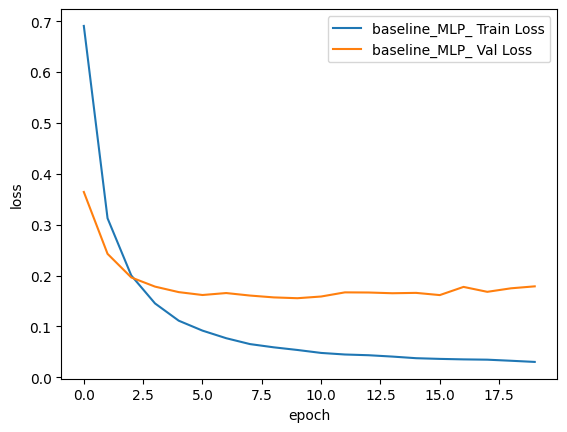

Finished Training


In [11]:
# train the model

# import the model
from FCN_class import FCN

# create the model
model = FCN(num_classes=6)
model.to(device)

# train the model
# pre_train_model(self, train_loader, val_loader, lr=1.e-4, epochs=50, patience=10)
model.pre_train_model(train_loader, val_loader, lr=1.e-4, epochs=50, patience=10)

# save the model
torch.save(model, 'baseline_model.pth')

                 precision    recall  f1-score   support

         Kinase       1.00      1.00      1.00      3522
           GPCR       0.99      0.99      0.99      3650
    Ion Channel       0.97      0.96      0.97       596
Nucler Receptor       0.99      0.99      0.99       550
       Protease       0.99      1.00      0.99      1616
    Transporter       0.93      0.94      0.94       360

       accuracy                           0.99     10294
      macro avg       0.98      0.98      0.98     10294
   weighted avg       0.99      0.99      0.99     10294

MCC: 0.9833870329483203


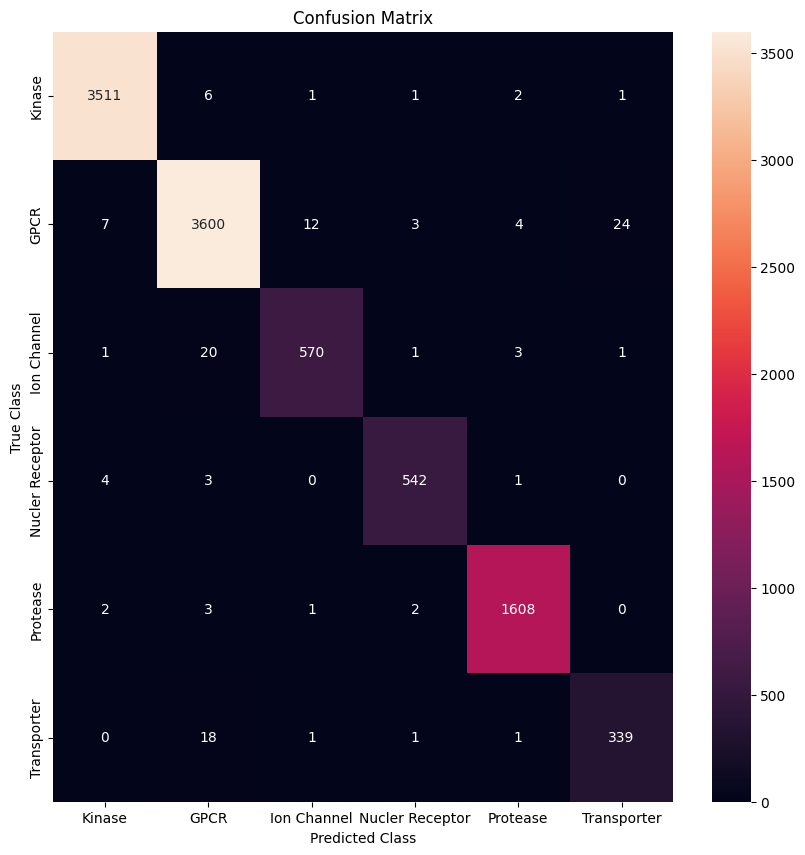

In [17]:
# test the model

test_loop(model, test_loader, prot_fam_names.values(), device)

In [16]:
# save the baseline model
# torch.save(model, 'baseline_model.pth')

# load the model: 
model = torch.load('baseline_model.pth')

## Transfer learning

### Pretraining

In [7]:
# import the model
from FCN_class import FCN

# create the model
model_to_pretain = FCN(num_classes=5)
model_to_pretain = model_to_pretain.to(device)

In [8]:
# get the non_transfer dataloaders
from data_loaders import TransferDataLoader
transfer_dataloader = TransferDataLoader(df)
non_transfer_data_loaders = transfer_dataloader.get_nontransfer_dataloaders()

non_transfer_train_loader, non_transfer_val_loader, non_transfer_test_loader = non_transfer_data_loaders['train'], non_transfer_data_loaders['val'], non_transfer_data_loaders['test']


Epoch: 1/50 | Train Loss: 0.4397631783089409 | Val Loss: 0.2653487907944193
Epoch: 2/50 | Train Loss: 0.2243704784484798 | Val Loss: 0.1820578324904971
Epoch: 3/50 | Train Loss: 0.15901603592363825 | Val Loss: 0.1801519321511317
Epoch: 4/50 | Train Loss: 0.1289924163231129 | Val Loss: 0.165334838578759
Epoch: 5/50 | Train Loss: 0.10498322364248956 | Val Loss: 0.17140327772096403
Epoch: 6/50 | Train Loss: 0.09386650330856938 | Val Loss: 0.1653817564805287
Epoch: 7/50 | Train Loss: 0.08502327322518248 | Val Loss: 0.15315919219279645
Epoch: 8/50 | Train Loss: 0.07920661524288515 | Val Loss: 0.1720188638308442
Epoch: 9/50 | Train Loss: 0.07159577952591636 | Val Loss: 0.15682564794001322
Epoch: 10/50 | Train Loss: 0.06937518768174926 | Val Loss: 0.15250665767000796
Epoch: 11/50 | Train Loss: 0.06545964492756888 | Val Loss: 0.16766379508874873
Epoch: 12/50 | Train Loss: 0.06115563916312072 | Val Loss: 0.17539827371046043
Epoch: 13/50 | Train Loss: 0.06308066052066963 | Val Loss: 0.1689044372

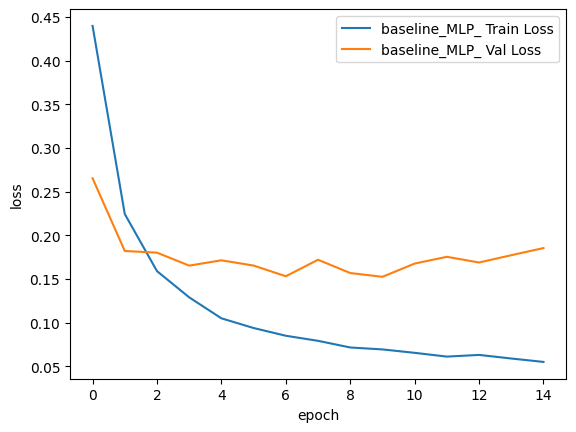

Finished Training


In [9]:
# pretrain the model

model_to_pretain.pre_train_model(non_transfer_train_loader, non_transfer_val_loader, lr=0.001, epochs=50, patience=5)

# save the model
torch.save(model_to_pretain, 'model_to_pretain.pth')

In [8]:
# save the pretrained model
# torch.save(model_to_pretain, 'model_to_pretain.pth')

# load the pretrained model: 
# model_to_pretain = torch.load('model_to_pretain.pth')

#### Test the pretrained model performance

Predictions: (9928,)
Labels: (9928,)
                 precision    recall  f1-score   support

         Kinase       0.98      0.98      0.98      3625
           GPCR       0.95      0.98      0.96      3672
    Ion Channel       0.95      0.82      0.88       575
Nucler Receptor       0.97      0.93      0.95       533
       Protease       0.97      0.95      0.96      1523

       accuracy                           0.96      9928
      macro avg       0.96      0.93      0.95      9928
   weighted avg       0.96      0.96      0.96      9928

MCC: 0.9479412342596791


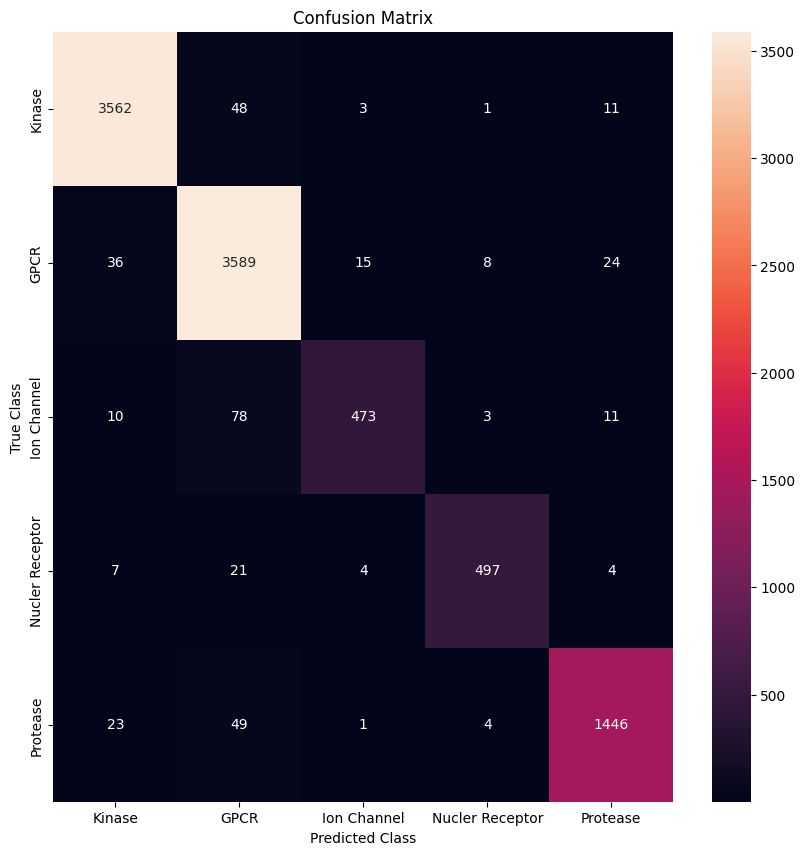

In [14]:
transfer_prot_fams = {k: v for k, v in prot_fam_names.items() if k != 5}

test_loop(model_to_pretain, non_transfer_test_loader, transfer_prot_fams.values())

In [15]:
# get the transfer dataloaders
transfer_data_loaders = transfer_dataloader.get_transfer_dataloaders()
transfer_train_loader, transfer_test_loader = transfer_data_loaders["train"], transfer_data_loaders["test"]


### Finetuning

#### Mode: Full-finetuning

In [16]:
mode = "full_fine_tune"
lr=1.e-5
epochs=5

model_full_finetune = copy.deepcopy(model_to_pretain)

model_full_finetune.fine_tune(mode, transfer_train_loader, lr = lr, epochs=epochs)

Epoch: 1/5 | Train Loss: -0.36239509057739505
Epoch: 2/5 | Train Loss: -1.5319638760841412
Epoch: 3/5 | Train Loss: -2.981296569108963
Epoch: 4/5 | Train Loss: -5.249581239793612
Epoch: 5/5 | Train Loss: -6.83168679734935


In [18]:
prot_fam_names

{0: 'Kinase',
 1: 'GPCR',
 2: 'Ion Channel',
 3: 'Nucler Receptor',
 4: 'Protease',
 5: 'Transporter'}

In [19]:

test_loop(model_full_finetune, transfer_test_loader, prot_fam_names.values(), device)

Predictions: (368,)
Labels: (368,)


ValueError: Number of classes, 3, does not match size of target_names, 6. Try specifying the labels parameter

#### Mode: Feature Transformer

In [ ]:
mode = "feature_transformer"
lr=1.e-5
epochs=5

model_feature_transformer = copy.deepcopy(model_to_pretain)

model_feature_transformer.fine_tune(mode, transfer_train_loader, lr = lr, epochs=epochs)

In [ ]:
test_loop(model_feature_transformer, test_loader, prot_fam_names.values(), device)

#### Mode: Shallow Classifier

In [ ]:
mode = "shallow_classifier"
lr=1.e-5
epochs=5

model_shallow_classifier = copy.deepcopy(model_to_pretain)

model_shallow_classifier.fine_tune(mode, transfer_train_loader, lr = lr, epochs=epochs)

In [ ]:
test_loop(model_shallow_classifier, test_loader, prot_fam_names.values(), device)